<center><h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">Keywords Extraction using KeyBERT </h1></center>

in this notebook i will use KeyBERT for keyword extraction using BERT (Bidirectional Encoder Representations from Transformers) which is a transformer-based model that generates contextualized word or sentence embeddings embeddings. KeyBERT is a minimal and easy-to-use Python library so it leverages the state-of-the-art language models provided by the Hugging Face Transformers library to extract keywords or key phrases from a given document. Here's a breakdown of how KeyBERT works and its core calculations:

---

### **KeyBERT in Keyword Extraction**
KeyBERT is designed to extract the most relevant keywords or key phrases from a text by combining the power of BERT embeddings with simple cosine similarity. It works as follows:

1. **Input Text**: You provide a document or text from which you want to extract keywords.
2. **Candidate Keywords/Phrases**: KeyBERT generates a list of candidate keywords or phrases (e.g., n-grams) from the text.
3. **BERT Embeddings**: It uses a pre-trained BERT model to generate embeddings (vector representations) for:
   - The entire document.
   - Each candidate keyword/phrase.
4. **Similarity Calculation**: KeyBERT computes the cosine similarity between the document embedding and each candidate keyword/phrase embedding.
5. **Ranking**: The candidates are ranked based on their similarity scores, and the top N keywords/phrases are returned as the most relevant.

---

### **Advantages of KeyBERT**
- **Context-Aware**: BERT embeddings capture the context of words, making KeyBERT effective for understanding nuanced meanings unlike traditonal techniques like TF-IDF whcih lack the context understanding.
- **Simple and Flexible**: It is easy to use and can be customized with different BERT models or similarity metrics.
- **No Training Required**: KeyBERT uses pre-trained BERT models, so no additional training is needed.

In summary, KeyBERT is a powerful tool for keyword extraction that combines BERT's contextual understanding with cosine similarity to identify the most relevant keywords or phrases from a document. Its core calculations rely on BERT embeddings and cosine similarity to rank and select keywords.

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Import Libraries</h1>

In [ ]:
# !pip install datasets keybert

from datasets import load_dataset
from keybert import KeyBERT
import pandas as pd
import re
import numpy as np 
import matplotlib.pyplot as plt 
import string
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from tqdm.notebook import tqdm
from collections import Counter
import time
nltk.download('punkt')
nltk.download('stopwords')

import spacy
# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.7 MB/s eta 0:00:00
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = load_dataset("Lettria/financial-articles")["train"].to_pandas()
df.head()

README.md:   0%|          | 0.00/388 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/41.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18415 [00:00<?, ? examples/s]

,source_name,content,url,origin
0,PRECIOUS-Gold hits over 4-mth high as dollar i...,"* Spot gold may rise to $1,357.54/oz - technic...",https://www.reuters.com/article/global-preciou...,www.reuters.com
1,Greeley and Hansen Appoints Two New Principals,"CHICAGO, Jan. 23, 2018 /PRNewswire/ -- Greeley...",http://www.cnbc.com/2018/01/23/pr-newswire-gre...,www.cnbc.com
2,Netflix Q4 earnings preview,Analysts expect Netflix to post a big quarter ...,https://www.cnbc.com/2018/01/22/netflix-q4-ear...,www.cnbc.com
3,BRIEF-Endeavour Silver Provides 2018 Productio...,"January 25, 2018 / 11:57 AM / in 9 minutes BRI...",https://www.reuters.com/article/brief-endeavou...,www.reuters.com
4,"Apple, Google and Microsoft top list of the mo...","For the second consecutive year, Apple and Goo...",https://www.cnbc.com/2018/01/18/apple-google-a...,www.cnbc.com


In [3]:
print(f"Dataset Shape:{df.shape}")
print(df.info())

Dataset Shape:(18415, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18415 entries, 0 to 18414
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_name  18415 non-null  object
 1   content      18415 non-null  object
 2   url          18415 non-null  object
 3   origin       18415 non-null  object
dtypes: object(4)
memory usage: 575.6+ KB
None


In [4]:
df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))
df.head()

,source_name,content,url,origin,word_count
0,PRECIOUS-Gold hits over 4-mth high as dollar i...,"* Spot gold may rise to $1,357.54/oz - technic...",https://www.reuters.com/article/global-preciou...,www.reuters.com,486
1,Greeley and Hansen Appoints Two New Principals,"CHICAGO, Jan. 23, 2018 /PRNewswire/ -- Greeley...",http://www.cnbc.com/2018/01/23/pr-newswire-gre...,www.cnbc.com,476
2,Netflix Q4 earnings preview,Analysts expect Netflix to post a big quarter ...,https://www.cnbc.com/2018/01/22/netflix-q4-ear...,www.cnbc.com,476
3,BRIEF-Endeavour Silver Provides 2018 Productio...,"January 25, 2018 / 11:57 AM / in 9 minutes BRI...",https://www.reuters.com/article/brief-endeavou...,www.reuters.com,221
4,"Apple, Google and Microsoft top list of the mo...","For the second consecutive year, Apple and Goo...",https://www.cnbc.com/2018/01/18/apple-google-a...,www.cnbc.com,462


In [5]:
# check the variety of word_count column numbers
df_sorted = df.sort_values(by='word_count', ascending=False)
df_sorted

,source_name,content,url,origin,word_count
15449,Deere Reports Second-Quarter Net Income of $1....,"MOLINE, Ill., May 18, 2018 /PRNewswire/ -- Dee...",http://www.cnbc.com/2018/05/18/pr-newswire-dee...,www.cnbc.com,7656
16378,Johnson Controls reports solid fiscal Q2 earni...,"CORK, Ireland, May 1, 2018 /PRNewswire/ -- Joh...",http://www.cnbc.com/2018/05/01/pr-newswire-joh...,www.cnbc.com,7377
7776,CNBC EXCLUSIVE: CNBC’S MEG TIRRELL INTERVIEWS ...,"WHEN: Today, Wednesday, March 28th\nFollowing ...",http://www.cnbc.com/2018/03/28/cnbc-exclusive-...,www.cnbc.com,7092
7573,Ribbon Communications Inc. Releases Fourth Qua...,"WESTFORD, Mass., March 1, 2018 /PRNewswire/ --...",http://www.cnbc.com/2018/03/01/pr-newswire-rib...,www.cnbc.com,6887
4879,AGNC Investment Corp. Announces Fourth 2017 Fi...,"BETHESDA, Md., Jan. 31, 2018 /PRNewswire/ -- A...",http://www.cnbc.com/2018/01/31/pr-newswire-agn...,www.cnbc.com,6879
...,...,...,...,...,...
16564,Chicago Rivet & Machine Co. Announces First Qu...,"NAPERVILLE, Ill., May 4, 2018 /PRNewswire/ -- ...",http://www.cnbc.com/2018/05/04/pr-newswire-chi...,www.cnbc.com,91
7147,AllianceBernstein Closed-End Funds Announce Di...,"NEW YORK, Feb. 16, 2018 /PRNewswire/ -- The Al...",http://www.cnbc.com/2018/02/16/pr-newswire-all...,www.cnbc.com,91
16198,U.S. Auto Parts: 1Q Earnings Snapshot,"CARSON, Calif. (AP) _ U.S. Auto Parts Network ...",https://www.cnbc.com/2018/05/08/the-associated...,www.cnbc.com,90
7853,RDS Advance Notice of Q1 2018 Results Announce...,"THE HAGUE, Netherlands, March 26, 2018 /PRNews...",http://www.cnbc.com/2018/03/26/pr-newswire-rds...,www.cnbc.com,83


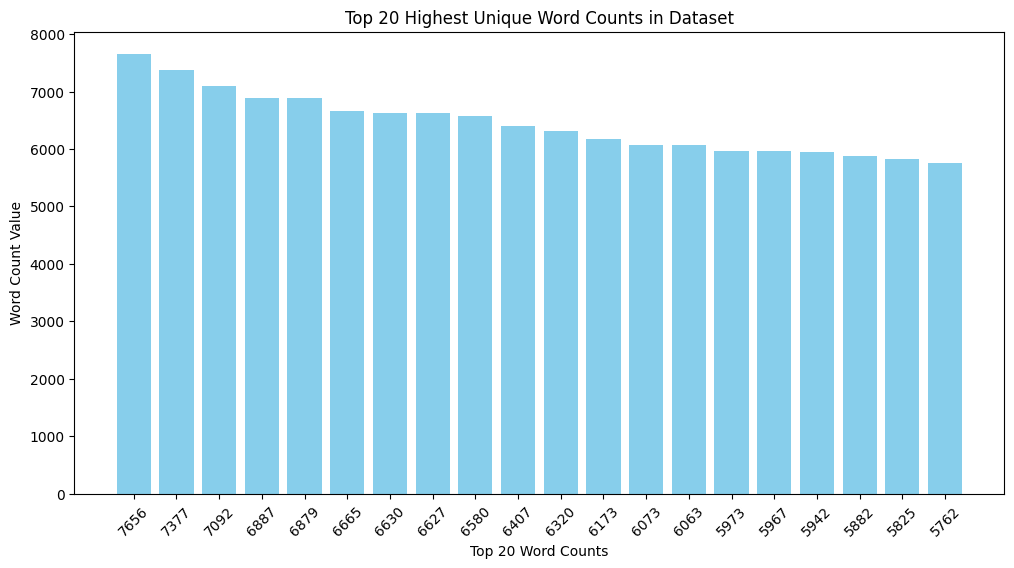

In [6]:
top_20_counts = sorted(df['word_count'].unique(), reverse=True)[:20]

plt.figure(figsize=(12, 6))
plt.bar(range(len(top_20_counts)), top_20_counts, color='skyblue')
plt.xticks(range(len(top_20_counts)), top_20_counts, rotation=45)
plt.xlabel("Top 20 Word Counts")
plt.ylabel("Word Count Value")
plt.title("Top 20 Highest Unique Word Counts in Dataset")
plt.show()

In [7]:
df.head()

,source_name,content,url,origin,word_count
0,PRECIOUS-Gold hits over 4-mth high as dollar i...,"* Spot gold may rise to $1,357.54/oz - technic...",https://www.reuters.com/article/global-preciou...,www.reuters.com,486
1,Greeley and Hansen Appoints Two New Principals,"CHICAGO, Jan. 23, 2018 /PRNewswire/ -- Greeley...",http://www.cnbc.com/2018/01/23/pr-newswire-gre...,www.cnbc.com,476
2,Netflix Q4 earnings preview,Analysts expect Netflix to post a big quarter ...,https://www.cnbc.com/2018/01/22/netflix-q4-ear...,www.cnbc.com,476
3,BRIEF-Endeavour Silver Provides 2018 Productio...,"January 25, 2018 / 11:57 AM / in 9 minutes BRI...",https://www.reuters.com/article/brief-endeavou...,www.reuters.com,221
4,"Apple, Google and Microsoft top list of the mo...","For the second consecutive year, Apple and Goo...",https://www.cnbc.com/2018/01/18/apple-google-a...,www.cnbc.com,462


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Text Preprocessing</h1>

In [8]:
# Define all the patterns
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Combine all the preprocessing steps into one function
def clean_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Replace all URLs with ''
    tweet = re.sub(urlPattern, '', tweet)
    
    # Replace @USERNAME with ''
    tweet = re.sub(userPattern, '', tweet)
    
    # Replace 3 or more consecutive letters by 2 letters
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    
    # Adding space on either side of '/' to separate words
    tweet = re.sub(r'/', ' / ', tweet)
    
    # Remove punctuations, links, mentions, and \r\n new line characters
    tweet = tweet.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet)
    tweet = re.sub(r'[^\x00-\x7f]', r'', tweet)
    banned_list = string.punctuation + 'Ã' + '±' + 'ã' + '¼' + 'â' + '»' + '§'
    table = str.maketrans('', '', banned_list)
    tweet = tweet.translate(table)
    
    # Clean hashtags
    tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    tweet = " ".join(word.strip() for word in re.split('#|_', tweet))
    
    # Filter special characters such as & and $
    tweet = ' '.join([word if ('$' not in word) and ('&' not in word) else '' for word in tweet.split(' ')])
    
    # Remove multiple spaces
    tweet = re.sub("\s\s+", " ", tweet)
    
    # Remove punctuation
    tweet = re.sub(f"[{re.escape(string.punctuation)}]", "", tweet)
    
    # Remove numbers
    tweet = re.sub(r"\d+", "", tweet)
    
    # Tokenization, lemmatization, and stopword removal using spaCy
    doc = nlp(tweet)
    tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and len(token.text) >= 3]
    
    # Join the tokens back into a single string
    cleaned_text = " ".join(tokens)
    
    return cleaned_text.strip()

df['cleaned_Text'] = df['content'].apply(clean_tweet)
df.head()

,source_name,content,url,origin,word_count,cleaned_Text
0,PRECIOUS-Gold hits over 4-mth high as dollar i...,"* Spot gold may rise to $1,357.54/oz - technic...",https://www.reuters.com/article/global-preciou...,www.reuters.com,486,spot gold rise technical speculator raise net ...
1,Greeley and Hansen Appoints Two New Principals,"CHICAGO, Jan. 23, 2018 /PRNewswire/ -- Greeley...",http://www.cnbc.com/2018/01/23/pr-newswire-gre...,www.cnbc.com,476,chicago jan prnewswire greeley hansen lead glo...
2,Netflix Q4 earnings preview,Analysts expect Netflix to post a big quarter ...,https://www.cnbc.com/2018/01/22/netflix-q4-ear...,www.cnbc.com,476,analyst expect netflix post big quarter bell m...
3,BRIEF-Endeavour Silver Provides 2018 Productio...,"January 25, 2018 / 11:57 AM / in 9 minutes BRI...",https://www.reuters.com/article/brief-endeavou...,www.reuters.com,221,january minute briefendeavour silver provi...
4,"Apple, Google and Microsoft top list of the mo...","For the second consecutive year, Apple and Goo...",https://www.cnbc.com/2018/01/18/apple-google-a...,www.cnbc.com,462,second consecutive year apple google top list ...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18415 entries, 0 to 18414
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   source_name   18415 non-null  object
 1   content       18415 non-null  object
 2   url           18415 non-null  object
 3   origin        18415 non-null  object
 4   word_count    18415 non-null  int64 
 5   cleaned_Text  18415 non-null  object
dtypes: int64(1), object(5)
memory usage: 863.3+ KB


In [10]:
content = df.iloc[15449]['cleaned_Text']
print(content)

moline ill prnewswire deere company nyse report net income billion second quarter end april share compare net income million share quarter end april month year net income attributable deere company million share compare billion share period year affect result second quarter month provisional adjustment provision income taxis enactment tax reform legislation december tax reform secondquarter result include favorable net adjustment provisional income taxis million month reflect unfavorable net provisional income tax expense million adjustment net income attributable deere company second quarter month year billion share billion share respectively information refer appendix nongaap financial measure note condense note interim consolidated financial statement accompany release worldwide net sale revenue increase percent billion second quarter rise percent billion month net sale equipment operation billion second quarter billion month compare billion billion period year john deere report qua

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Implement KeyBERT</h1>

<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">1- Index Approach</h3>

we will try KeyBERT for specific article with index  `15449`   which is considered the largest article in our dataset and let's see how it work

In [ ]:
kw_model = KeyBERT()

# Extract keywords from a specific article 
def extract_keywords_from_article(text, nr_keywords=10, use_diversity=True):
    """Extract keywords from an article text using KeyBERT"""
    if not text or len(text.strip()) == 0:
        return []
        
    try:
        # Use MMR for diversity if specified
        if use_diversity:
            keywords = kw_model.extract_keywords(
                text, 
                keyphrase_ngram_range=(1, 2),  # Extract single words and bigrams
                stop_words='english',
                use_mmr=True,          # Maximum Marginal Relevance for diversity cuz KeyBERT sometimes returns similar keywords so implementing Maximal Marginal Relevance (MMR) ensure diversity
                diversity=0.7,         # higher value means more diverse keywords
                nr_candidates=20,   # # Number of candidate keywords to consider
                top_n=nr_keywords
            )
        else:
            keywords = kw_model.extract_keywords(
                text, 
                keyphrase_ngram_range=(1, 2),
                stop_words='english',
                use_maxsum=True,  #  Uses the MaxSum algorithm to select keywords based on their similarity to the document
                nr_candidates=20,
                top_n=nr_keywords
            )
        return keywords
    except Exception as e:
        print(f"Error extracting keywords: {e}")
        return []


sample_index = 15449
sample_text = df['cleaned_Text'].iloc[sample_index]
sample_keywords = extract_keywords_from_article(sample_text, use_diversity=False)

print(f"Keywords for article at index {sample_index}:")
for keyword, score in sample_keywords:
    print(f"- {keyword}: {score:.4f}")

Keywords for article at index 15449:
- demand equipment: 0.3798
- supplier ramp: 0.3806
- taxis operating: 0.3815
- profit report: 0.3820
- income net: 0.3825
- john deere: 0.3831
- tractor: 0.3837
- taxis provision: 0.3896
- income consolidated: 0.3917
- company deere: 0.4164


In [ ]:
# with diversity
sample_index = 15449
sample_text = df['cleaned_Text'].iloc[sample_index]
sample_keywords = extract_keywords_from_article(sample_text, use_diversity=True)

print(f"Keywords for article at index {sample_index}:")
for keyword, score in sample_keywords:
    print(f"- {keyword}: {score:.4f}")

Keywords for article at index 15449:
- income taxis: 0.4682
- deere report: 0.3623
- repurchase change: 0.2527
- implementation organizational: 0.1877
- compare net: 0.1786
- wellpositione capitalize: 0.1244
- export include: 0.1092
- average number: 0.0451
- delay closing: 0.0219
- greenhouse gas: -0.0426


<h2 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">2- Semantic Search Approach</h2>

**now i will try KeyBERT by searching for article containing specific word or similar to it then doing keywords extraction for these aricles and print all their keywords with their score. its done by finding semantically similar articles using embeddings without pre-filtering by exact matches directly computing embeddings and rank by similarity computing embeddings and similarity scores for all articles in the dataset. This approach ensures that semantically related articles (even those without the exact query term) are included in the results.**

In [ ]:
def improved_semantic_search(query, df, column='cleaned_Text', top_n=30, batch_size=32):

    """
    Input Parameters:

    df: The DataFrame containing the dataset (e.g., financial articles).
    column: The column in the DataFrame that contains the text to search (default: cleaned_Text).
    top_n: The number of top results to return (default: 30).
    batch_size: The number of documents to process at a time (default: 32
    """

    start_time = time.time()
    print(f"Starting semantic search for '{query}'...")
    
    # Get embedding for query
    query_embedding = kw_model.model.embed([query])[0]
    
    # Process document embeddings in batches
    all_embeddings = []
    total_batches = (len(df) + batch_size - 1) // batch_size
    
    print(f"Computing embeddings for {len(df)} documents in {total_batches} batches...")
    
    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df[column].iloc[i:i+batch_size].tolist()
        # Filter out empty texts
        batch_texts = [text if pd.notna(text) and len(text.strip()) > 0 else "" for text in batch_texts]
        
        try:
            batch_embeddings = kw_model.model.embed(batch_texts)
            all_embeddings.extend(batch_embeddings)
        except Exception as e:
            # Handle errors and pad with zeros
            print(f"Error in batch {i//batch_size + 1}: {e}")
            all_embeddings.extend([np.zeros(kw_model.model.embed(["test"])[0].shape) for _ in range(len(batch_texts))])
    
    # Compute cosine similarity between the query embedding and each document embedding is calculated, result is a list of similarity scores, one for each document
    similarities = cosine_similarity([query_embedding], all_embeddings)[0]
    
    # Create a DataFrame with indices and similarity scores
    results_df = pd.DataFrame({
        'original_index': df.index,
        'similarity': similarities
    })
    
    # Sort by similarity score and get top N results
    results_df = results_df.sort_values('similarity', ascending=False).head(top_n)
    
    # Get the corresponding articles
    top_indices = results_df['original_index'].tolist()
    filtered_df = df.loc[top_indices].copy()
    
    # Add similarity scores to filtered DataFrame
    filtered_df['similarity'] = results_df['similarity'].values
    
    # Sort by similarity
    filtered_df = filtered_df.sort_values('similarity', ascending=False).reset_index(drop=True)
    
    end_time = time.time()
    print(f"Semantic search completed in {end_time - start_time:.2f} seconds")
    print(f"Found {len(filtered_df)} semantically related articles")
    
    # Extract keywords from each filtered article
    keywords_list = []
    
    print("Extracting keywords from top articles...")
    for idx, row in filtered_df.iterrows():
        if pd.notna(row[column]) and row[column].strip() != "":
            article_keywords = extract_keywords_from_article(row[column], nr_keywords=5, use_diversity=True)
            
            for keyword, score in article_keywords:
                keywords_list.append({
                    'article_idx': idx,
                    'source': row['source_name'] if 'source_name' in row else 'Unknown',
                    'similarity': row['similarity'],
                    'keyword': keyword,
                    'keyword_score': score
                })
    
    # Create a DataFrame of the keywords
    keywords_df = pd.DataFrame(keywords_list)
    return filtered_df, keywords_df


query_term = "netflix"
filtered_articles, keyword_results = improved_semantic_search(query_term, df)

# display results
if not filtered_articles.empty:
    print(f"\nTop 3 articles related to '{query_term}':")
    for idx, row in filtered_articles.head(3).iterrows():
        print(f"\nArticle {idx} (Similarity: {row['similarity']:.4f})")
        print(f"Source: {row['source_name']}")
        print(f"Word count: {row['word_count']}")
        
        # Get the keywords for this article
        article_keywords = keyword_results[keyword_results['article_idx'] == idx]
        print("Keywords:")
        for _, kw_row in article_keywords.iterrows():
            print(f"- {kw_row['keyword']}: {kw_row['keyword_score']:.4f}")

Starting semantic search for 'netflix'...
Computing embeddings for 18415 documents in 576 batches...


  0%|          | 0/576 [00:00<?, ?it/s]

Semantic search completed in 55.17 seconds
Found 30 semantically related articles
Extracting keywords from top articles...

Top 3 articles related to 'netflix':

Article 0 (Similarity: 0.5901)
Source: Success of 'Bright' shows even Netflix's rotten movies are blockbuster hits
Word count: 276
Keywords:
- rating netflix: 0.6619
- opening theater: 0.2038
- healthy line: 0.1546
- cite success: 0.1348
- capitalize shift: 0.0905

Article 1 (Similarity: 0.5267)
Source: Netflix earnings Q4 2017
Word count: 241
Keywords:
- netflix earning: 0.6709
- monday report: 0.3095
- admit company: 0.1654
- highdefinition plan: 0.1462
- like crown: 0.0994

Article 2 (Similarity: 0.5114)
Source: Netflix to beat subscriber expectations for fourth quarter, analyst predicts
Word count: 332
Keywords:
- raise netflix: 0.6008
- research say: 0.1950
- ce consumer: 0.1718
- write despite: 0.0276
- potential entrant: 0.0093


In [ ]:
def improved_semantic_search(query, df, column='cleaned_Text', top_n=30, batch_size=32):

    start_time = time.time()
    print(f"Starting semantic search for '{query}'...")
    
    # Get embedding for query
    query_embedding = kw_model.model.embed([query])[0]
    
    # Process document embeddings in batches
    all_embeddings = []
    total_batches = (len(df) + batch_size - 1) // batch_size
    
    print(f"Computing embeddings for {len(df)} documents in {total_batches} batches...")
    
    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df[column].iloc[i:i+batch_size].tolist()
        # Filter out empty texts
        batch_texts = [text if pd.notna(text) and len(text.strip()) > 0 else "" for text in batch_texts]
        
        try:
            batch_embeddings = kw_model.model.embed(batch_texts)
            all_embeddings.extend(batch_embeddings)
        except Exception as e:
            # Handle errors and pad with zeros
            print(f"Error in batch {i//batch_size + 1}: {e}")
            all_embeddings.extend([np.zeros(kw_model.model.embed(["test"])[0].shape) for _ in range(len(batch_texts))])
    
    # Compute similarity scores for all documents
    similarities = cosine_similarity([query_embedding], all_embeddings)[0]
    
    # Create a DataFrame with indices and similarity scores
    results_df = pd.DataFrame({
        'original_index': df.index,
        'similarity': similarities
    })
    
    # Sort by similarity score and get top N results
    results_df = results_df.sort_values('similarity', ascending=False).head(top_n)
    
    # Get the corresponding articles
    top_indices = results_df['original_index'].tolist()
    filtered_df = df.loc[top_indices].copy()
    
    # Add similarity scores to filtered DataFrame
    filtered_df['similarity'] = results_df['similarity'].values
    
    # Sort by similarity
    filtered_df = filtered_df.sort_values('similarity', ascending=False).reset_index(drop=True)
    
    end_time = time.time()
    print(f"Semantic search completed in {end_time - start_time:.2f} seconds")
    print(f"Found {len(filtered_df)} semantically related articles")
    
    # Extract keywords from each filtered article
    keywords_list = []
    
    print("Extracting keywords from top articles...")
    for idx, row in filtered_df.iterrows():
        if pd.notna(row[column]) and row[column].strip() != "":
            article_keywords = extract_keywords_from_article(row[column], nr_keywords=5, use_diversity=False)
            
            for keyword, score in article_keywords:
                keywords_list.append({
                    'article_idx': idx,
                    'source': row['source_name'] if 'source_name' in row else 'Unknown',
                    'similarity': row['similarity'],
                    'keyword': keyword,
                    'keyword_score': score
                })
    
    # Create a DataFrame of the keywords
    keywords_df = pd.DataFrame(keywords_list)
    
    return filtered_df, keywords_df


# 2. Perform improved semantic search
query_term = "netflix"
filtered_articles, keyword_results = improved_semantic_search(query_term, df)

# Display results
if not filtered_articles.empty:
    print(f"\nTop 3 articles related to '{query_term}':")
    for idx, row in filtered_articles.head(3).iterrows():
        print(f"\nArticle {idx} (Similarity: {row['similarity']:.4f})")
        print(f"Source: {row['source_name']}")
        print(f"Word count: {row['word_count']}")
        
        # Get the keywords for this article
        article_keywords = keyword_results[keyword_results['article_idx'] == idx]
        print("Keywords:")
        for _, kw_row in article_keywords.iterrows():
            print(f"- {kw_row['keyword']}: {kw_row['keyword_score']:.4f}")

Starting semantic search for 'netflix'...
Computing embeddings for 18415 documents in 576 batches...


  0%|          | 0/576 [00:00<?, ?it/s]

Semantic search completed in 55.17 seconds
Found 30 semantically related articles
Extracting keywords from top articles...

Top 3 articles related to 'netflix':

Article 0 (Similarity: 0.5901)
Source: Success of 'Bright' shows even Netflix's rotten movies are blockbuster hits
Word count: 276
Keywords:
- smith netflix: 0.4881
- movie viewership: 0.4915
- expect netflix: 0.5142
- netflix continue: 0.5537
- netflix unique: 0.5708

Article 1 (Similarity: 0.5267)
Source: Netflix earnings Q4 2017
Word count: 241
Keywords:
- hulu: 0.3622
- content investment: 0.3627
- earning report: 0.3737
- netflixs chief: 0.4968
- netflix remain: 0.5494

Article 2 (Similarity: 0.5114)
Source: Netflix to beat subscriber expectations for fourth quarter, analyst predicts
Word count: 332
Keywords:
- streaming: 0.2975
- streaming subscriber: 0.3457
- tuesday netflix: 0.4188
- despite netflix: 0.4312
- netflix ceo: 0.4914


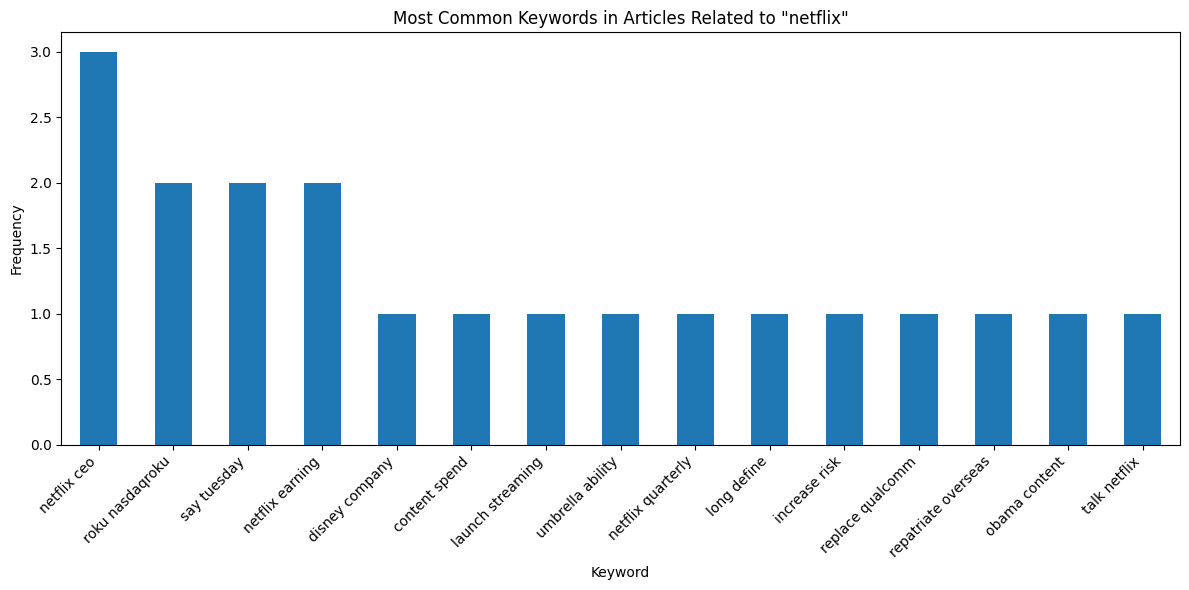

In [29]:
# Visualize keyword distribution across articles
if not keyword_results.empty:
    # Get the top 15 keywords by frequency
    keyword_counts = keyword_results['keyword'].value_counts().head(15)
    
    plt.figure(figsize=(12, 6))
    keyword_counts.plot(kind='bar')
    plt.title(f'Most Common Keywords in Articles Related to "{query_term}"')
    plt.xlabel('Keyword')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
query_term = "Economic collapse"  # here it wil search for snot only Economic collapse but also similar embeddings like Economic crises
filtered_articles, keyword_results = improved_semantic_search(query_term, df)

# Display results
if not filtered_articles.empty:
    print(f"\nTop 3 articles related to '{query_term}':")
    for idx, row in filtered_articles.head(3).iterrows():
        print(f"\nArticle {idx} (Similarity: {row['similarity']:.4f})")
        print(f"Source: {row['source_name']}")
        print(f"Word count: {row['word_count']}")
        
        # Get the keywords for this article
        article_keywords = keyword_results[keyword_results['article_idx'] == idx]
        print("Keywords:")
        for _, kw_row in article_keywords.iterrows():
            print(f"- {kw_row['keyword']}: {kw_row['keyword_score']:.4f}")

Starting semantic search for 'Economic collapse'...
Computing embeddings for 18415 documents in 576 batches...


  0%|          | 0/576 [00:00<?, ?it/s]

Semantic search completed in 54.99 seconds
Found 30 semantically related articles
Extracting keywords from top articles...

Top 3 articles related to 'Economic collapse':

Article 0 (Similarity: 0.4100)
Source: To Spot the Next Financial Crisis, Look Who Was Spared by the Last One
Word count: 131
Keywords:
- fix bank: 0.4067
- hardhit financial: 0.4202
- spend decade: 0.4213
- depression decade: 0.4593
- crisis explain: 0.4857

Article 1 (Similarity: 0.3832)
Source: EMERGING MARKETS-Brazil real slumps despite intervention amid emerging market selloff
Word count: 468
Keywords:
- america argentine: 0.3868
- emergingmarket central: 0.3883
- highlight emergingmarket: 0.3914
- peso weaken: 0.3957
- brazil currency: 0.4384

Article 2 (Similarity: 0.3773)
Source: Economist fears a 30 percent stock market correction with consumer spending ‘maxed out’
Word count: 680
Keywords:
- market return: 0.3556
- investment growth: 0.3626
- economy skew: 0.3721
- global economy: 0.3751
- recession possibl